<a href="https://colab.research.google.com/gist/jeremy-dl/8ece30805fca2cc1a52c67767a55f8fb/descarttes-labs-crop-yield-demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Predicting crop yield using weather and satellite observations with the Descartes Labs Platform

In [0]:
!pip install descarteslabs && descarteslabs auth login

In [2]:
import descarteslabs as dl
from descarteslabs.client.services.tasks import AsyncTasks, as_completed
import numpy as np
import pandas
import json
import shapely
import shapely.geometry
import matplotlib
import matplotlib.pyplot as plt
import folium
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pprint import pprint
import pickle
import calendar
import sklearn
import sklearn.cluster
import sklearn.ensemble

from descarteslabs.client.services import Catalog
from descarteslabs.client.services import Storage

storage_client = Storage()
catalog = Catalog()

product_id = '6298b97d846a85f9045e8173d1f052c571b48cae:demo:crop:iowa:v1'

/usr/local/lib/python3.6/dist-packages/pkg_resources/__init__.py:1151: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  self, resource_name
/usr/local/lib/python3.6/dist-packages/pkg_resources/__init__.py:1151: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  self, resource_name


### Find Corn

In [0]:
# load yield reference data
with open('nass_county_iowa_corn_2017.json') as f:
    reference = json.load(f)

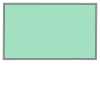

In [4]:
# find Crawford County, IA
slug = dl.places.find('iowa_west-central_crawford')[0]['slug']
county_shape = dl.places.shape(slug)
geometry = shapely.geometry.shape(county_shape['geometry'])
geometry

#### Find all the corn in Carroll County, Iowa

In [5]:
scenes, geo_ctx = dl.scenes.search(
    geometry,
    products=['usda:cdl'],
    start_datetime='2017-01-01',
    end_datetime='2018-01-01',
    limit=500
)
scenes, geo_ctx

(SceneCollection of 1 scene
   * Dates: Dec 31, 2017 to Dec 31, 2017
   * Products: usda:cdl: 1, AOI(geometry=<shapely.geom...x7f3e686249e8>,
     resolution=30,
     crs='+proj=aea +l...s=m +no_defs ',
     align_pixels=True,
     bounds=(-95.672771, 41.863147, -95.090851, 42.211408),
     bounds_crs='EPSG:4326',
     shape=None))

In [6]:
arr = scenes.mosaic("class", geo_ctx, mask_alpha=False)
arr.shape # one band, 1310 pixels tall by 1587 pixels wide

(1, 1310, 1587)

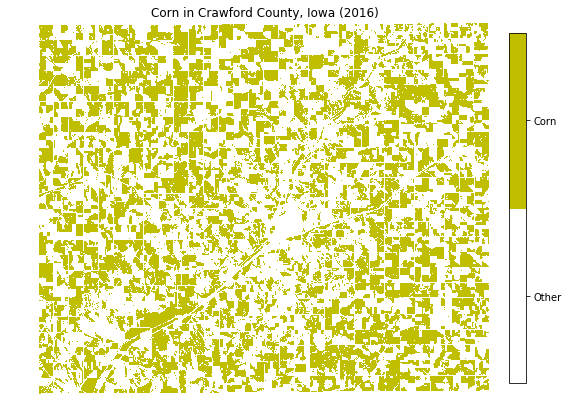

In [7]:
# Filter to just corn
corn = np.where(arr == 1, 1, 0)[0,:,:]

# Colormap
colorlist = ['w', 'y']
cmap = colors.ListedColormap(colorlist)
bounds = [0, 1, 2]
norm = colors.BoundaryNorm(bounds, cmap.N)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
cax = plt.imshow(corn, cmap=cmap, norm=norm)
plt.title('Corn in Crawford County, Iowa (2016)')
cbar = fig.colorbar(cax, ticks=[0.5, 1.5], orientation='vertical', fraction=0.036, pad=0.04)
cbar.ax.set_yticklabels(['Other', 'Corn']) 
plt.axis('off')
plt.tight_layout()

### Calculate vegetation indices

In [8]:
# Search for NDVI scenes
# Pass in geo_ctx instead of AOI to ensure returned scenes are in correct CRS
scenes, geo_ctx = dl.scenes.search(
    geo_ctx,
    products=['8291fd932b469d8d81701dd6079d64b0fabc5f93:moody:l8_2017_veg_healthmax:v1'],
    start_datetime='2017-01-01',
    end_datetime='2017-12-31',
    limit=500
)
scenes

SceneCollection of 6 scenes
  * Dates: Jul 01, 2017 to Jul 01, 2017
  * Products: 8291fd932b469d8d81701dd6079d64b0fabc5f93:moody:l8_2017_veg_healthmax:v1: 6

In [9]:
arr = scenes.mosaic('veg_healthmax', geo_ctx, mask_alpha=False)[0, :, :]
arr.shape #same shape as previous steps

(1310, 1587)

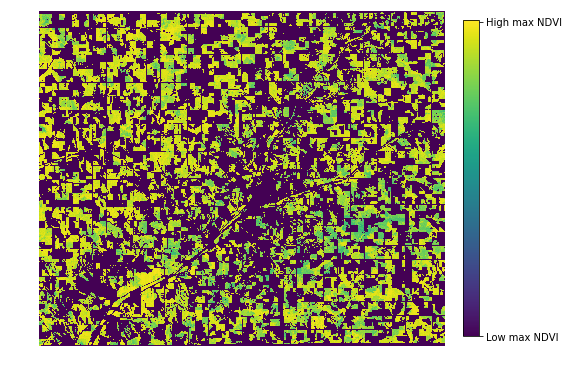

In [10]:
corn_ndvi = np.where(corn == 1, arr, 0)

fig, ax = plt.subplots(figsize=(8, 8))
cax = plt.imshow(corn_ndvi)
cbar = fig.colorbar(
    cax,
    ticks=[0, 240],
    orientation='vertical',
    fraction=0.036,
    pad=0.04
)
cbar.ax.set_yticklabels(['Low max NDVI', 'High max NDVI'])
plt.axis('off')
plt.tight_layout()

### Calculate weather variables

In [11]:
''' DLTiles to create a global tiling across our AOI '''

shape = dl.places.shape('north-america_united-states_iowa')
resolution = 30
tile_dimension = 2048
pad = 0

tiles = dl.raster.dltiles_from_shape(
    resolution=resolution, 
    tilesize=tile_dimension, 
    pad=pad, 
    shape=shape
)

print('Number of tiles = {}'.format(len(tiles['features'])))

Number of tiles = 58


In [12]:
# Create a product in your Descartes Labs user namespace
from descarteslabs.client.services.catalog import Catalog
auth = dl.Auth()

# Get Descartes Labs username
user = auth.payload['name']

# generate product ID from username
product_id = '{}:{}:demo:crop:iowa'.format(
    auth.namespace,
    user.lower().replace(' ', '')
) 

product_title = '{} Growing Degree Days'.format(user) 

print(f"""
The next cells will create the following product:
    title: {product_title}
    id:    {product_id}
""")


The next cells will create the following product:
    title: Jeremy Malczyk Growing Degree Days
    id:    df523eb50eb35de5cfb549959056fb71cf88a88c:jeremymalczyk:demo:crop:iowa



In [13]:
# Check if Product already exists, remove if it does
already_exists = list(filter(lambda p: p.get('id') == product_id, dl.Catalog().own_products()))
if already_exists:
    print("Product already exists, removing existing one...")
    dl.Catalog().remove_product(product_id, cascade=True)
    print("...done")

product = dl.Catalog().add_product(
    product_id,
    title=product_title,
    description="GDD calculated from GSOD for crop demo"
)['data']['id']
print(product)

band_id = dl.Catalog().add_band(
    product_id,
    'gdd',
    jpx_layer=0,
    srcfile=0,
    srcband=1,  
    nbits=16,
    dtype='Int16',
    nodata=0,
    data_range=[0, 2**16 - 1],
    type='spectral',
    default_range=(0, 5500),
    data_unit_description='0.01 celsius',
    colormap_name='viridis'
)['data']['id']
print(band_id)

print("Done! View your product here: https://catalog.descarteslabs.com/?/product/{}".format(product_id))

Product already exists, removing existing one...
...done
df523eb50eb35de5cfb549959056fb71cf88a88c:jeremymalczyk:demo:crop:iowa
df523eb50eb35de5cfb549959056fb71cf88a88c:jeremymalczyk:demo:crop:iowa:gdd
Done! View your product here: https://catalog.descarteslabs.com/?/product/df523eb50eb35de5cfb549959056fb71cf88a88c:jeremymalczyk:demo:crop:iowa


In [0]:
tile = tiles['features'][0]
# shape = shape,
start_date = '2017-05-01'
end_date = '2017-10-15'
product = 'fcd57a7bf668c5b65d49c5e32130a2c0a5281322:daily:gsod:interp:dev-v0'

bands = ['tavg']

# ----------------------------------
# SCENES

tile_geo_ctx = dl.scenes.DLTile.from_key(tile.properties.key)

scenes, geo_ctx = dl.scenes.search(
#     tile['geometry'],
    tile_geo_ctx,
    products=[product],
    start_datetime=start_date,
    end_datetime=end_date
)

# tile_geo_ctx = dl.scenes.DLTile.from_key(tile.properties.key)

new_image_stack, new_meta = scenes.stack(
    bands,
    tile_geo_ctx,
    raster_info=True,
    mask_alpha=False,
    bands_axis=-1
)

# ---------------------------------
# RASTER + METADATA
available_scenes = dl.metadata.search(
    products=[product],
    geom=tile['geometry'],
    start_datetime=start_date,
    end_datetime=end_date
)

# scene ids
ids = [scene['id'] for scene in available_scenes['features']]

# get each image as ndarray
old_image_stack, old_meta = dl.raster.stack(
    ids,
    bands=bands,
    dltile=tile,
    cutline=shape,
    data_type='Int16'
)

In [0]:
old_dates = [a.properties.acquired for a in available_scenes.features]
new_dates = [a.properties.acquired for a in scenes]

old_dates.sort()
new_dates.sort()

In [0]:
for o, n in zip(old_dates, new_dates):
    if o != n:
        print(f"These don't match: {o} ... {n}")

In [17]:
old = np.unique(old_image_stack)
new = np.unique(new_image_stack)

print(old.dtype, new.dtype)
print(len(old), len(new))

int16 int16
190 1891


/usr/local/lib/python3.6/dist-packages/descarteslabs/scenes/_display.py:181: RuntimeWarning: overflow encountered in short_scalars
  disp /= (vmax - vmin)


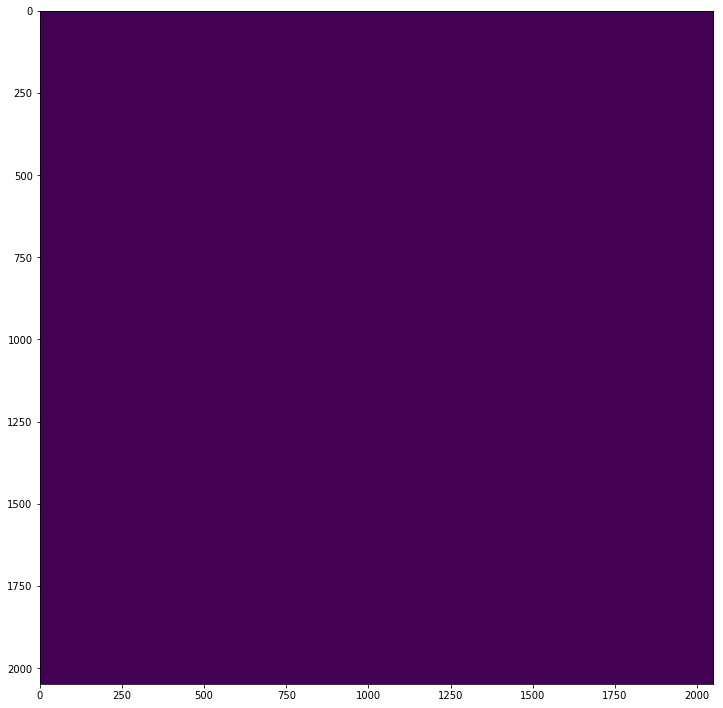

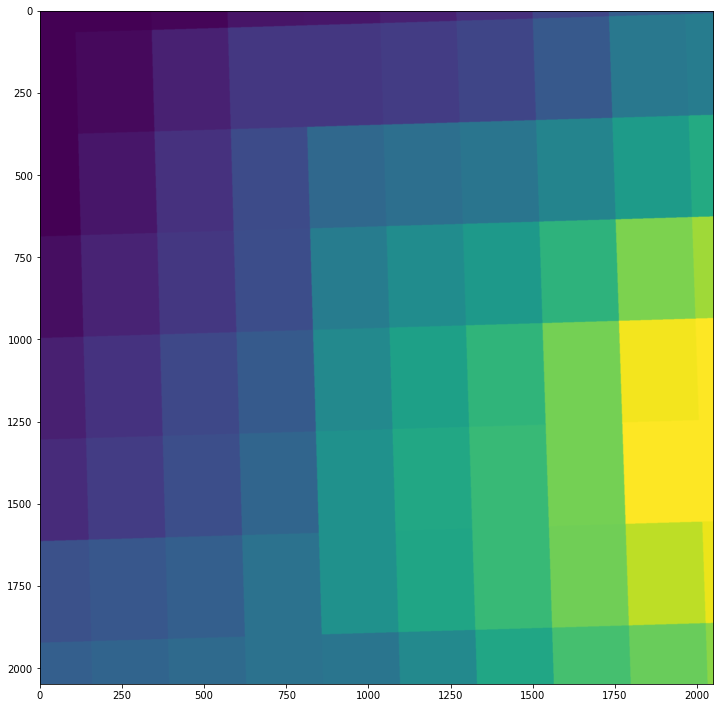

In [18]:
dl.scenes.display(old_image_stack[-1], bands_axis=-1, colormap='viridis')
dl.scenes.display(new_image_stack[-1], bands_axis=-1, colormap='viridis')

In [0]:
def calculate_gdd_task(tile, shape, start_date, end_date, input_product, output_product):
    """ predict water over dltile with Tasks """
    
    import descarteslabs as dl
    from descarteslabs.client.services.catalog import Catalog
    from descarteslabs.client.services.storage import Storage
    
    storage_client = Storage()
    catalog = Catalog()
    
    import os
    import numpy as np
    import pickle


    def search_and_raster(product, tile, shape, start_date, end_date):
        
        
      scenes, geo_ctx = dl.scenes.search(
         tile['geometry'],
         products=[product],
         start_datetime=start_date,
         end_datetime=end_date
      )

      tile_geo_ctx = dl.scenes.DLTile.from_key(tile['properties']['key'])

      image_stack, meta = scenes.stack(
          ['tavg'],
          tile_geo_ctx,
          raster_info=True,
          mask_alpha=False,
          bands_axis=-1
      )
        
      # This will need fixing
      print(image_stack.shape)    # keep getting (100, 8, 10, 1)
                                 # should be (100, 2048, 2048, 1)
      dl.scenes.display(image_stack[0], bands_axis=-1)

      uniques = np.unique(image_stack[0])
      print(f"first layer has {uniques} unique values")

      return image_stack[:, :, :, 0], meta[0]


    def calc_gdd(image_stack):
        ''' calculate gdd for each pixel'''

        gdd = image_stack - 1000
        gdd = np.where(gdd < 0, 0, gdd)
        
        # calculate cumulative GDD 
        # scale to fit in uint16
        cum_gdd = cum_gdd = np.ndarray.astype((np.sum(gdd, axis=0) / 100), 'uint16')
        
        return cum_gdd
    
    ''' predict water over each compositing period '''
    outdir = os.path.join(os.path.expanduser('~'), 'temp')
    if not os.path.isdir(outdir):
            os.makedirs(outdir)

    key = tile['properties']['key']
    outfile = 'gdd_{}_{}_{}.tif'.format(key, start_date, end_date)

    # get imagery and stats for each product

    image_stack, meta = search_and_raster(input_product, tile, shape, start_date, end_date)
    stats = calc_gdd(image_stack)
    
    # save to product to Catalog    
    upload_id = catalog.upload_ndarray(
        stats,
        output_product,
        outfile,
        raster_meta=meta
    )
        
    return "Processed dltile {}\nupload_id {}".format(key, upload_id)

(100, 2048, 2048, 1)


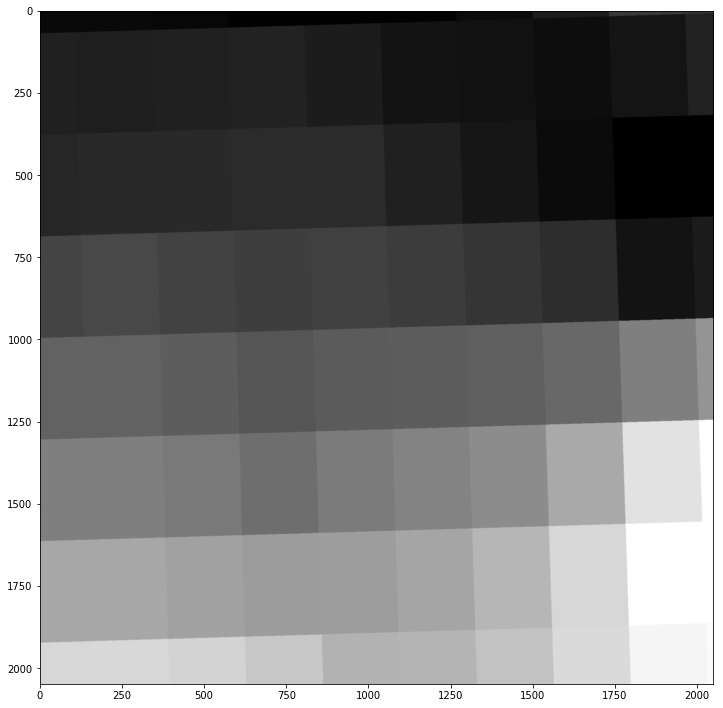

first layer has [462 469 470 473 474 475 476 478 479 480 481 484 485 486 487 489 491 492
 493 497 499 501 502 503 504 505 507 514 517 518 519 521 524 527 533 534
 536 538 543 547 551 552 554 556 557 558 563 564 565 571 574 580 582 583
 584 588 598 601 603 611 624] unique values


'Processed dltile 2048:0:30.0:14:3:74\nupload_id gdd_2048:0:30.0:14:3:74_2017-05-01_2017-10-15.tif'

In [20]:
# TEST THE TASK FUNCTION
calculate_gdd_task(
    tiles['features'][0],
    shape,
    '2017-05-01',
    '2017-10-15',
    'fcd57a7bf668c5b65d49c5e32130a2c0a5281322:daily:gsod:interp:dev-v0',
    product_id
)

(100, 2048, 2048, 1)


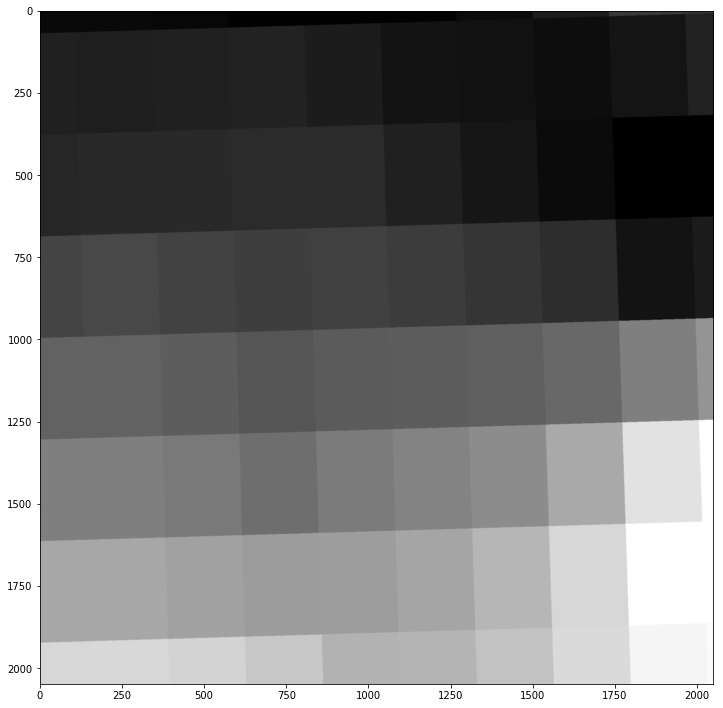

first layer has [462 469 470 473 474 475 476 478 479 480 481 484 485 486 487 489 491 492
 493 497 499 501 502 503 504 505 507 514 517 518 519 521 524 527 533 534
 536 538 543 547 551 552 554 556 557 558 563 564 565 571 574 580 582 583
 584 588 598 601 603 611 624] unique values


'Processed dltile 2048:0:30.0:14:3:74\nupload_id gdd_2048:0:30.0:14:3:74_2017-05-01_2017-10-15.tif'

In [21]:
# TEST THE TASK FUNCTION
calculate_gdd_task(
    tiles['features'][0],
    shape,
    '2017-05-01',
    '2017-10-15',
    'fcd57a7bf668c5b65d49c5e32130a2c0a5281322:daily:gsod:interp:dev-v0',
    product_id
)

In [0]:
''' DL Tasks to run the job '''

from descarteslabs.client.services.tasks import AsyncTasks, as_completed
at = AsyncTasks()

async_function = at.create_function(calculate_gdd_task, 
                                    name="demo-crop-yield",
                                    memory='10Gi',
                                    image='us.gcr.io/dl-ci-cd/images/tasks/public/py3.6/default:v2019.02.12',
                                    task_timeout=5000
                                    )

In [0]:
''' Submit DL Tasks '''

input_product = 'fcd57a7bf668c5b65d49c5e32130a2c0a5281322:daily:gsod:interp:dev-v0'

tasks = [async_function(tile, shape, '2017-05-01', '2017-10-15', input_product, product_id) 
         for tile in tiles['features']]

### Monitor the tail generation tasks

In [24]:
from IPython.display import IFrame
IFrame('https://monitor.descarteslabs.com', width="100%", height="600px")

In [25]:
# Data are now available through the programmatic API

available_scenes = dl.metadata.search(products=[product_id])

print(len(available_scenes['features']))

1


### Develop a predictive model

#### Train a model

In [26]:


from sklearn.tree import DecisionTreeRegressor

features = []
values = []
for slug in sorted(reference.keys()):
    features.append(reference[slug]['gdd'] + reference[slug]['ndvi'])
    values.append(reference[slug]['yld'])
    
regr = DecisionTreeRegressor(max_depth=7)
regr.fit(features, values)
print('r2 = {}'.format(regr.score(features, values)))

r2 = 0.9217109502643273


#### Predict yield over Illinois 

In [0]:


with open('nass_county_illinois_corn_2017_predictor.json') as f:
    predict_data = json.load(f)

features = []
values = []
geometries = []
for slug in sorted(predict_data.keys()):
    features.append(list(predict_data[slug]['gdd']) + list(predict_data[slug]['ndvi']))
    values.append(predict_data[slug]['yld'])
    geometries.append({'properties': {'name': slug},
                       'geometry': predict_data[slug]['geometry'],
                       'type': 'Feature'})
    
yield_predictions = regr.predict(np.array(features))

In [28]:
''' Plot the predictions '''

df = pandas.DataFrame.from_dict({'yield': yield_predictions, 'name': sorted(predict_data.keys())})
counties = {'type': 'FeatureCollection', 'features': geometries}

m = folium.Map(location=[40.0468423, -89.1366099], zoom_start=6)
m.choropleth(geo_data=counties, 
           data=df,
           columns=['name', 'yield'],
           key_on='feature.properties.name',
           fill_color='YlGn',
           fill_opacity=1,
           legend_name='Predicted Corn Yield - 2017 (bu/acre)')
m

/usr/local/lib/python3.6/dist-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/pkg_resources/__init__.py:1151: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  self, resource_name
/usr/local/lib/python3.6/dist-packages/pkg_resources/__init__.py:1151: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  self, resource_name
/usr/local/lib/python3.6/dist-packages/pkg_resources/__init__.py:1151: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  self, resource_name
/usr/local/lib/python3.6/dist-packages/pkg_resources/__init__.p